# Visualization of the challenge's data

Load the required libraries

In [1]:
%pip install "numpy>=2.2.0" "pandas>=2.0.0" "requests>=2.32.0" "scikit-learn>=1.6.0" -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests

Define some global constants

In [3]:
# This URL comes from the data service provided in the challenge
HOST = "http://localhost:8777"
DATA_ENDPOINT = f"{HOST}/api/v1/animals/data"

Request the data and load it into a dataframe

In [4]:
response = requests.get(f"{DATA_ENDPOINT}?number_of_datapoints=1000")

if response.ok:
    data = response.json()
    X = pd.DataFrame(data)

X.head()

,walks_on_n_legs,height,weight,has_wings,has_tail
0,4,2.937382,2946.069052,False,True
1,2,1.808298,67.708173,False,True
2,2,0.426638,2.661609,True,True
3,2,0.210008,1.721195,True,True
4,2,1.910102,42.860967,False,True


Basic data exploration

In [5]:
# Let´s convert the boolean columns to integers for easier visualization
# False -> 0, True -> 1
viz_data = X.copy()
viz_data["has_tail"] = viz_data["has_tail"].astype("int8")
viz_data["has_wings"] = viz_data["has_wings"].astype("int8")

viz_data.head()

,walks_on_n_legs,height,weight,has_wings,has_tail
0,4,2.937382,2946.069052,0,1
1,2,1.808298,67.708173,0,1
2,2,0.426638,2.661609,1,1
3,2,0.210008,1.721195,1,1
4,2,1.910102,42.860967,0,1


In [6]:
viz_data.describe()

,walks_on_n_legs,height,weight,has_wings,has_tail
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,2.963000,1.560279,1132.404993,0.282000,0.979000
std,1.022094,1.498055,2038.800017,0.450198,0.143456
min,1.000000,0.135686,0.040060,0.000000,0.000000
25%,2.000000,0.370062,3.825692,0.000000,1.000000
50%,2.000000,1.627909,54.225500,0.000000,1.000000
75%,4.000000,2.563111,545.737181,1.000000,1.000000
max,5.000000,9.952241,6839.403323,1.000000,1.000000


Histograms of all features

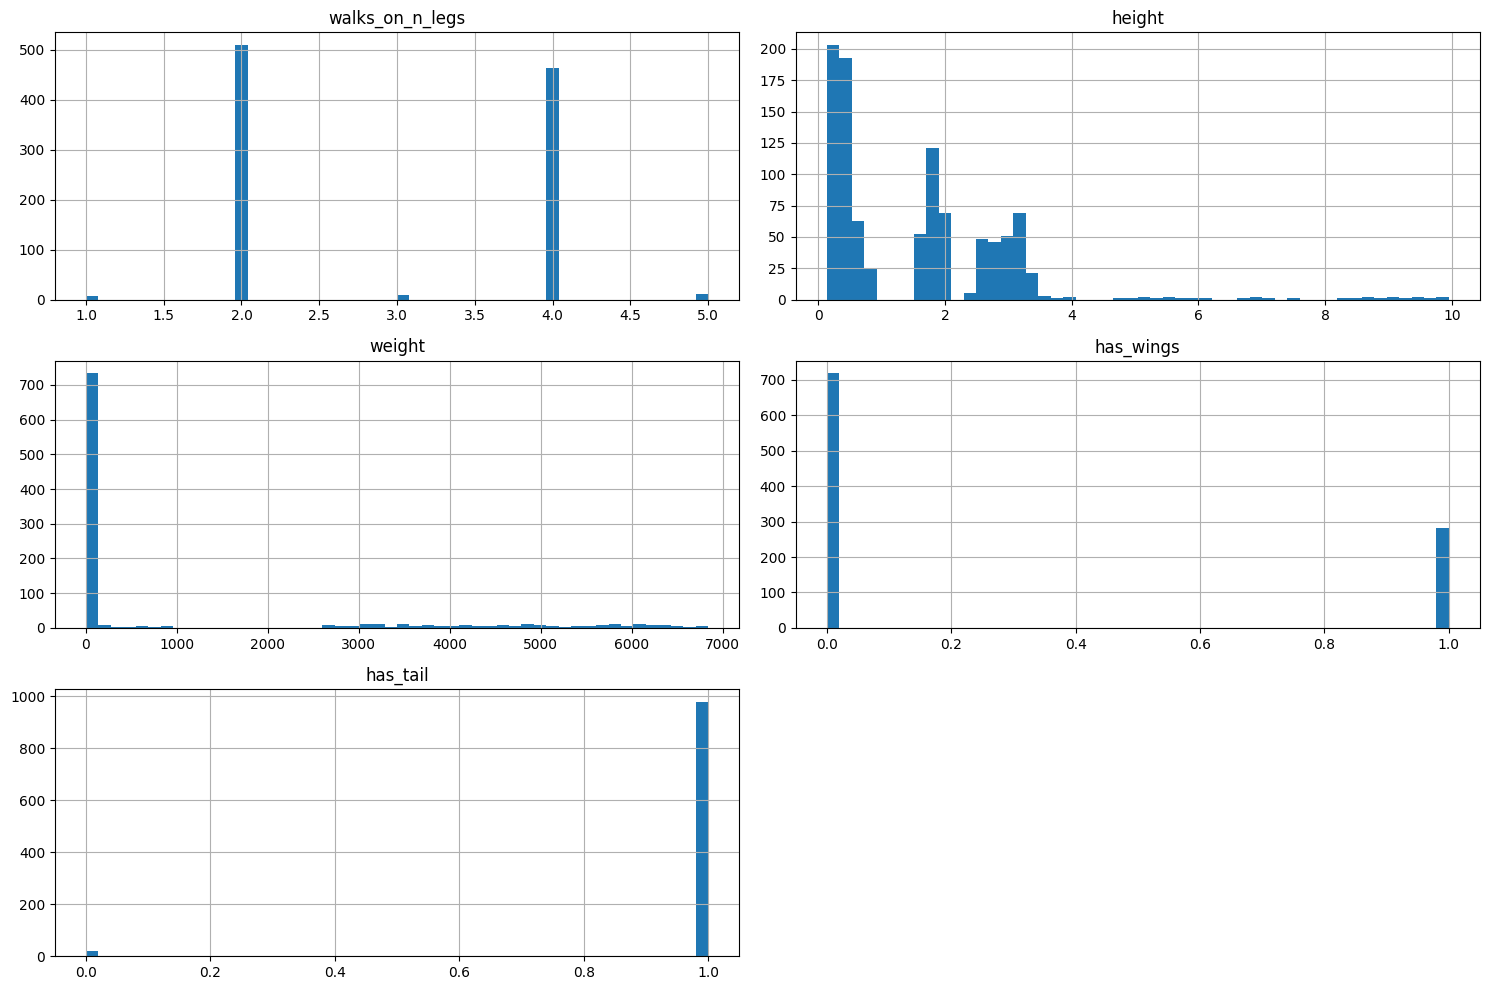

In [7]:
viz_data.hist(bins=50, figsize=(15, 10), layout=(3, 2))
plt.tight_layout()
plt.show()

Let's take a step back and think about the data we have and the domain knowledge we have about the problem.

The columns in the dataset are:
- walks_on_n_legs: the number of legs the animal walks on
- height: the height of the animal in meters
- weight: the weight of the animal in kilograms
- has_tail: whether the animal has a tail
- has_wings: whether the animal has wings

We are interesting in classifying the animals into four categories:
- Kangaroo
- Chicken
- Dog
- Elephant

Visually, how could we differentiate between these animals?

The first thing that comes to mind is size! Elephants are much larger than the other animals and chickens are specially small, that could be a good feature to differentiate between them.

Another feature that could be useful is the number of legs the animals walks on. Kangaroos and chickens walk on two legs, while dogs and elephants walk on four legs.

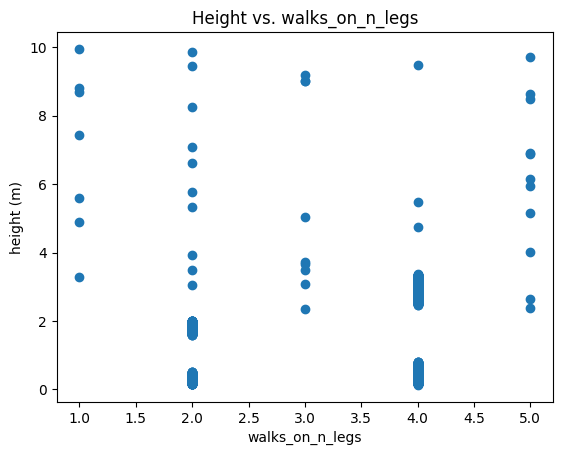

In [8]:
plt.scatter(X["walks_on_n_legs"], X["height"])
plt.title("Height vs. walks_on_n_legs")
plt.xlabel("walks_on_n_legs")
plt.ylabel("height (m)")
plt.show()

There are some interesting patterns in the data, but visualization is not great. Let's try adding jitter to the data points to make it easier to see the patterns.

In [9]:
jitter = np.random.uniform(-0.05, 0.05, len(X))
X["y_with_jitter"] = X["height"] + jitter
jitter = np.random.uniform(-0.05, 0.05, len(X))
X["x_with_jitter"] = X["walks_on_n_legs"] + jitter

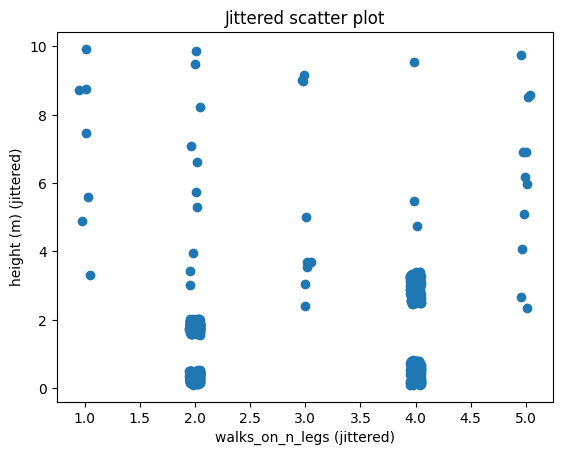

In [10]:
plt.scatter(X["x_with_jitter"], X["y_with_jitter"])
plt.title("Jittered scatter plot")
plt.xlabel("walks_on_n_legs (jittered)")
plt.ylabel("height (m) (jittered)")
plt.show()

Now that is interesting! We have managed to separate the data points into four clusters. There is some noise, but we can remove the outliers later or maybe our model can handle them.

Let's try to identify each cluster.

- Top left: Walks on 2 legs and measure between 1 and 2 meters. This is probably the kangaroo cluster.
- Bottom left: Walks on 2 legs, but measures less than 1 meter. This may be the chickens!
- Top right: Walks on 4 legs and its height is between 2 and 4 meters. This must be the elephants.
- Bottom right: Walks on 4 legs and its height is between 0 and 1 meters. This is probably the dogs.

Let's validate our assumptions by using the rest of the feautures we have.

First, we know chickens are the only animals on our classification with wings. Let's check if the cluster we identified as chickens has wings.

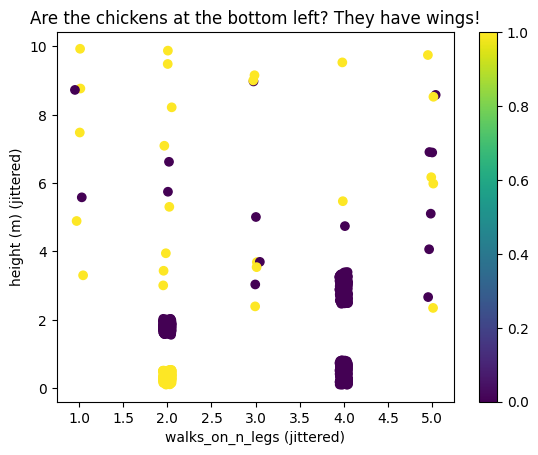

In [11]:
plt.scatter(X["x_with_jitter"], X["y_with_jitter"], c=X["has_wings"])
plt.title("Are the chickens at the bottom left? They have wings!")
plt.xlabel("walks_on_n_legs (jittered)")
plt.ylabel("height (m) (jittered)")
plt.colorbar()
plt.show()

Bingo! Let's check the elephants now, they must be the heaviest animals in our classification...

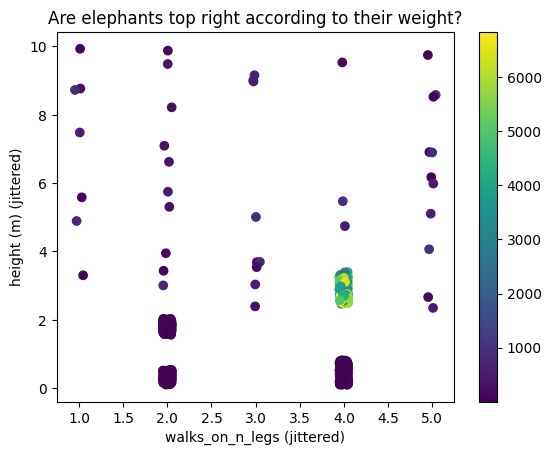

In [12]:
plt.scatter(X["x_with_jitter"], X["y_with_jitter"], c=X["weight"])
plt.title("Are elephants top right according to their weight?")
plt.xlabel("walks_on_n_legs (jittered)")
plt.ylabel("height (m) (jittered)")
plt.colorbar()
plt.show()

Then we can be sure that the other two clusters are the kangaroos and the dogs by the `walks_on_n_legs` feature.

So to solve this problem we can use a non-supervised clustering algorithm to identify the clusters (this should also take care of most outliers) and then use a rule-based approach to label automatically the clusters based on the other features.

- Kangaroos: Cluster of animals that walk on 2 legs and does not have wings.
- Chickens: Cluster of animals that walk on 2 legs and have wings.
- Elephants: Cluster of animals that walk on 4 legs and are the heaviest in average.
- Dogs: Cluster of animals that walk on 4 legs and are not the heaviest in average.